        Proof of Concept
**Predictive Anomaly Detection & Incident prevention for SRE Production Monitoring Using Machine Learning**
                                                                      ----Vardharaj Konar


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#Importing Required libraries for our model

In [ ]:
# Loading the data
url = "https://raw.githubusercontent.com/logpai/loghub/master/BGL/BGL_2k.log_structured.csv"
df = pd.read_csv(url)

df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d-%H.%M.%S.%f')
df.set_index('Time', inplace=True)

#EDA: Exploratory Data Analysis
print("=== DataFrame Shape ===")
print(df.shape)  # Rows, Columns

print("\n=== DataFrame Columns ===")
print(df.columns.tolist())

print("\n=== Data Types ===")
print(df.dtypes)

print("\n=== Head (first 5 rows) ===")
print(df.head())

print("\n=== Tail (last 5 rows) ===")
print(df.tail())

print("\n=== Missing Values Per Column ===")
print(df.isnull().sum())





=== DataFrame Shape ===
(2000, 12)

=== DataFrame Columns ===
['LineId', 'Label', 'Timestamp', 'Date', 'Node', 'NodeRepeat', 'Type', 'Component', 'Level', 'Content', 'EventId', 'EventTemplate']

=== Data Types ===
LineId            int64
Label            object
Timestamp         int64
Date             object
Node             object
NodeRepeat       object
Type             object
Component        object
Level            object
Content          object
EventId          object
EventTemplate    object
dtype: object

=== Head (first 5 rows) ===
                            LineId Label   Timestamp        Date  \
Time                                                               
2005-06-03 15:42:50.675872       1     -  1117838570  2005.06.03   
2005-06-03 15:42:53.276129       2     -  1117838573  2005.06.03   
2005-06-03 15:49:36.156884       3     -  1117838976  2005.06.03   
2005-06-03 15:49:38.026704       4     -  1117838978  2005.06.03   
2005-06-03 16:47:20.730545       5     -  11178

In [ ]:
# FEATURE ENGINEERING
# Aggregate logs by minute to get per-minute event counts
event_counts = df.resample('1T').count()['EventId']

# Create rolling averages to capture trends in event frequency
df_feat = pd.DataFrame({
    'count_1min': event_counts,                                     # 1-minute event count
    'count_3min': event_counts.rolling(3, min_periods=1).mean(),    # 3-minute rolling avg
    'count_5min': event_counts.rolling(5, min_periods=1).mean(),    # 5-minute rolling avg
}).fillna(0)


/tmp/ipython-input-3969534744.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  event_counts = df.resample('1T').count()['EventId']


In [ ]:


# Prepare an empty feature dataframe
df_feat = pd.DataFrame(index=df.resample('1min').count().index)

# 1. ERROR/WARNING messages per minute
if 'Level' in df.columns:
    err_warn_counts = df[df['Level'].isin(['ERROR', 'WARNING'])].resample('1min').count()['EventId']
    df_feat['error_warn_per_min'] = err_warn_counts.fillna(0)
    print("\nSample of error_warn_per_min feature:")
    print(df_feat['error_warn_per_min'].head())
else:
    df_feat['error_warn_per_min'] = 0
    print("\nNo 'Level' column found. error_warn_per_min set to 0.")

# 2. Average message length per minute
if 'Content' in df.columns:
    avg_msg_len = df['Content'].str.len().resample('1min').mean()
    df_feat['avg_msg_length'] = avg_msg_len.fillna(0)
    print("\nSample of avg_msg_length feature:")
    print(df_feat['avg_msg_length'].head())
else:
    df_feat['avg_msg_length'] = 0
    print("\nNo 'Content' column found. avg_msg_length set to 0.")

# Show combined features
print("\nCombined feature DataFrame sample:")
print(df_feat.head())



Sample of error_warn_per_min feature:
Timestamp
1970-01-01    49
Freq: min, Name: error_warn_per_min, dtype: int64

Sample of avg_msg_length feature:
Timestamp
1970-01-01    49.8475
Freq: min, Name: avg_msg_length, dtype: float64

Combined feature DataFrame sample:
            error_warn_per_min  avg_msg_length
Timestamp                                     
1970-01-01                  49         49.8475


In [ ]:


# synthetic labeling
df_feat['label'] = (df_feat['count_1min'] > df_feat['count_1min'].quantile(0.7)).astype(int)

# FEATURES & TARGET
feature_cols = [
    'count_1min', 'count_3min', 'count_5min',
    'error_warn_per_min', 'avg_msg_length'
]
# Ensuring only existing columns are selected
feature_cols = [col for col in feature_cols if col in df_feat.columns]

X = df_feat[feature_cols]
y = df_feat['label']

# DATA CHECK
print("df_feat shape:", df_feat.shape)
print("X shape:", X.shape)
print("Label counts:\n", y.value_counts())

#  TRAIN/TEST SPLIT
if len(X) > 1 and y.nunique() > 1:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print("Training set shape:", X_train.shape)
    print("Test set shape:", X_test.shape)
    print("Features used:", feature_cols)
else:
    print("\nNot enough data for a train/test split. Please check your feature engineering or add more log data.")


df_feat shape: (307652, 4)
X shape: (307652, 3)
Label counts:
 label
0    306272
1      1380
Name: count, dtype: int64
Training set shape: (246121, 3)
Test set shape: (61531, 3)
Features used: ['count_1min', 'count_3min', 'count_5min']



----- Logistic Regression -----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     61255
           1       1.00      1.00      1.00       276

    accuracy                           1.00     61531
   macro avg       1.00      1.00      1.00     61531
weighted avg       1.00      1.00      1.00     61531

AUC: 1.000


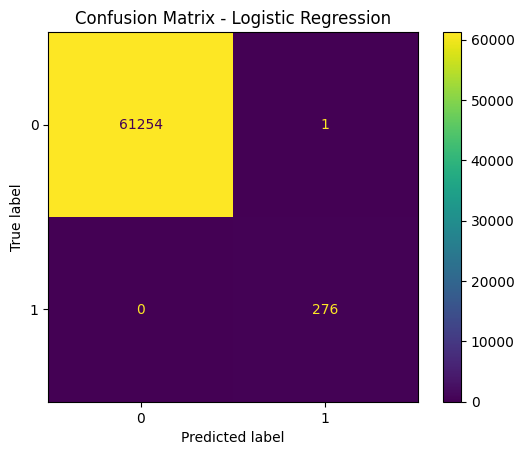


----- Decision Tree -----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     61255
           1       1.00      1.00      1.00       276

    accuracy                           1.00     61531
   macro avg       1.00      1.00      1.00     61531
weighted avg       1.00      1.00      1.00     61531

AUC: 1.000


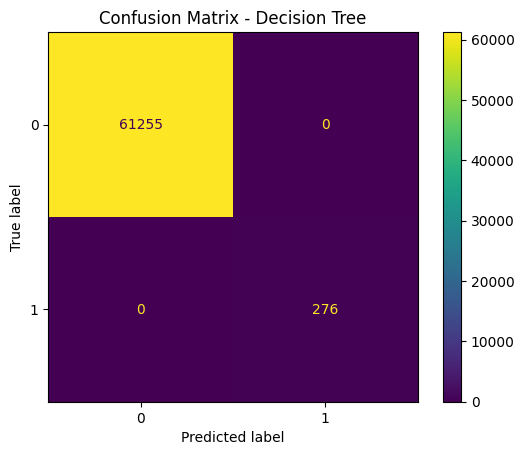


----- Random Forest -----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     61255
           1       1.00      1.00      1.00       276

    accuracy                           1.00     61531
   macro avg       1.00      1.00      1.00     61531
weighted avg       1.00      1.00      1.00     61531

AUC: 1.000


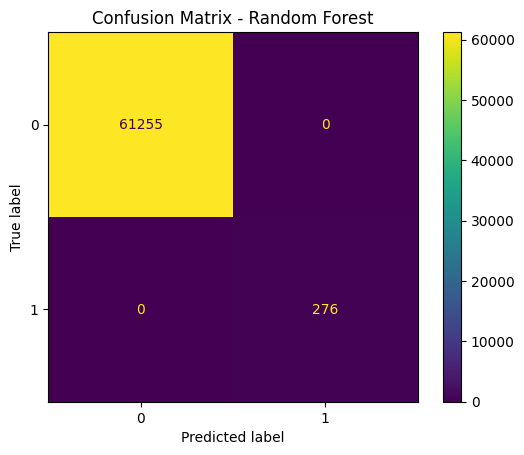

In [ ]:
#  MODEL SETUP
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n----- {name} -----")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    except Exception as e:
        auc = None
    print(classification_report(y_test, y_pred))
    if auc:
        print(f"AUC: {auc:.3f}")
    results[name] = {"acc": acc, "auc": auc}

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


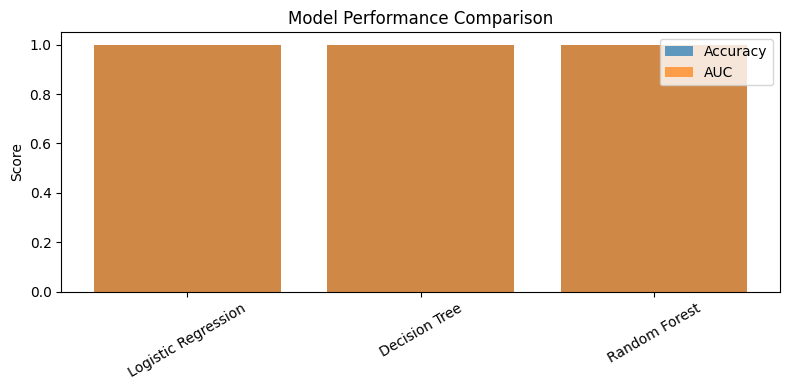

In [ ]:
# SUMMARY BARPLOT
accs = [results[m]['acc'] for m in models]
aucs = [results[m]['auc'] if results[m]['auc'] else 0 for m in models]

plt.figure(figsize=(8,4))
plt.bar(models.keys(), accs, alpha=0.7, label='Accuracy')
plt.bar(models.keys(), aucs, alpha=0.7, label='AUC')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Choosing best model (AUC preferred, then accuracy)
best_name = max(results, key=lambda k: (results[k]['auc'] if results[k]['auc'] else 0, results[k]['acc']))
best_model = models[best_name]
print(f"\nBest model: {best_name}")


Best model: Decision Tree


In [ ]:
# SYSTEM PREDICTION ALERTS (Last 10 Minutes)
print("\n[System Prediction Alerts for Latest 10 Minutes]")
latest_X = X.tail(10)
latest_index = latest_X.index
latest_preds = best_model.predict(latest_X)
try:
    latest_probs = best_model.predict_proba(latest_X)[:, 1]
except:
    latest_probs = [None] * len(latest_preds)

for ts, pred, prob in zip(latest_index, latest_preds, latest_probs):
    if pred == 1:
        if prob is not None:
            print(f"[ALERT] System failure predicted at {ts} (probability: {prob:.2f})")
        else:
            print(f"[ALERT] System failure predicted at {ts}")
        print("[ACTION] restart_application_server()")
    else:
        if prob is not None:
            print(f"[INFO] System stable at {ts} (probability of failure: {prob:.2f})")
        else:
            print(f"[INFO] System stable at {ts}")


[System Prediction Alerts for Latest 10 Minutes]
[INFO] System stable at 2006-01-03 07:04:00 (probability of failure: 0.00)
[INFO] System stable at 2006-01-03 07:05:00 (probability of failure: 0.00)
[INFO] System stable at 2006-01-03 07:06:00 (probability of failure: 0.00)
[INFO] System stable at 2006-01-03 07:07:00 (probability of failure: 0.00)
[INFO] System stable at 2006-01-03 07:08:00 (probability of failure: 0.00)
[INFO] System stable at 2006-01-03 07:09:00 (probability of failure: 0.00)
[INFO] System stable at 2006-01-03 07:10:00 (probability of failure: 0.00)
[INFO] System stable at 2006-01-03 07:11:00 (probability of failure: 0.00)
[INFO] System stable at 2006-01-03 07:12:00 (probability of failure: 0.00)
[ALERT] System failure predicted at 2006-01-03 07:13:00 (probability: 1.00)
[ACTION] restart_application_server()
